# Validate the outputs! Regression!

In [1]:
# !pip install xgboost
# !pip install shap

In [31]:
import pandas as pd
from rdkit import Chem
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import shap
import multiprocessing as mp
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Get Data

In [6]:
dtypes=defaultdict(lambda:"float")
dtypes['cmp1ID'] = 'category'
dtypes['cmp1name'] = 'category'
dtypes['SMILES'] = 'category'
df = pd.read_csv("../../data/IL/model_data_with_descriptors.csv", dtype=dtypes, na_values=["na"])
df = df.rename(columns={'Viscosity[Liquid]/Pa&#8226;s':'Viscosity', 
                   'Electrical_conductivity[Liquid]/S/m':"ElecConductivity", 
                   'Specific_density[Liquid]/kg/m3': 'Density'
                  })
print(df.info())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315 entries, 0 to 3314
Columns: 5674 entries, Temperature/K to chiralPhMoment
dtypes: category(3), float64(5671)
memory usage: 143.5 MB
None
Index(['Temperature/K', 'Pressure/kPa', 'Density', 'cmp1ID', 'cmp1name',
       'SMILES', 'Viscosity', 'ElecConductivity', 'MW', 'AMW',
       ...
       's1_numAroBonds', 's2_numAroBonds', 's3_numAroBonds', 's4_numAroBonds',
       's34_size', 's34_relSize', 's34_phSize', 's34_phRelSize',
       'chiralMoment', 'chiralPhMoment\r'],
      dtype='object', length=5674)


In [7]:
# Feature clean-up
df.dropna(axis=1, how='any', inplace=True)          # Remove any column that contains missing data
df = df.loc[:, ~df.isin([np.inf, -np.inf]).any()]   # Delete columns that contain at least 1 inf
df = df.loc[:, ~df.isnull().any()]                  # Delete columns that contain at least 1 nan
df = df.loc[:, df.nunique() != 1]                   # Delete columns that have all elements the same
columns_with_na = df.columns[df.applymap(lambda x: 'na' in str(x)).any()] # Identify columns with 'na' values in any of their rows
df = df.drop(columns=columns_with_na) # Drop columns with 'na' values

In [9]:
replaces= {}
for col in df.columns:
    if '[' in col or ']' in col or '<' in col:
        replaces[col] = col.replace('[','_').replace(']','_').replace('<','_')
df = df.rename(columns=replaces)        

In [10]:
outputs = ['Viscosity', 'ElecConductivity', 'Density']
irrelevant = ['cmp1ID', 'cmp1name', 'SMILES']
inputs = list(set(df.columns).difference(set(outputs)).difference(set(irrelevant)))

## Feature & Label data

In [94]:
X = df[inputs]
y = df[outputs]

In [95]:
scaler = StandardScaler() # Scale the feature values
X_scaled = scaler.fit_transform(X) # Scale the feature values

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1, test_size=0.25, shuffle=True)

In [97]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

In [98]:
evalset = [(X_train, y_train), (X_test,y_test)]
# evalset = [(X_test,y_test)]

In [99]:
n = 50
params = {
#     "eta": 0.05,
#     "max_depth": 10,
    "tree_method": "gpu_hist",
    "gpu_id":0,
    "objective": "reg:squarederror",
    "n_jobs":mp.cpu_count() // 2,
    "n_estimators":n,
#     "eval_metric":'logloss', 
#     "device": "cuda",
#     "enable_categorical":True,
#     "max_cat_to_onehot":1, 
}
# params = {
#     "objective": "reg:squarederror", 
#     "tree_method": "gpu_hist", 
#     "gpu_id":0, 
#     "max_cat_to_onehot":1, 
#     "enable_categorical":True,
#     "n_estimators":n,
#     "predictor": "gpu_predictor",
# }
# params = {"objective": "reg:squarederror", "tree_method": "hist"}

model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train, eval_set=evalset)
# model = xgb.train(
#     params=params,
#     dtrain=dtrain_reg,
#     num_boost_round=n,
# )

[0]	validation_0-rmse:512.68849	validation_1-rmse:511.84754
[1]	validation_0-rmse:359.87350	validation_1-rmse:358.49699
[2]	validation_0-rmse:252.86326	validation_1-rmse:251.22029
[3]	validation_0-rmse:178.00684	validation_1-rmse:176.66740
[4]	validation_0-rmse:125.54617	validation_1-rmse:124.38870
[5]	validation_0-rmse:88.77313	validation_1-rmse:87.78187
[6]	validation_0-rmse:62.97044	validation_1-rmse:62.22449
[7]	validation_0-rmse:44.87264	validation_1-rmse:44.28132
[8]	validation_0-rmse:32.18287	validation_1-rmse:31.88667
[9]	validation_0-rmse:23.32929	validation_1-rmse:23.31950
[10]	validation_0-rmse:17.13931	validation_1-rmse:17.49017
[11]	validation_0-rmse:12.88946	validation_1-rmse:13.58563
[12]	validation_0-rmse:9.88949	validation_1-rmse:10.94894
[13]	validation_0-rmse:7.87018	validation_1-rmse:9.21023
[14]	validation_0-rmse:6.52628	validation_1-rmse:8.12890
[15]	validation_0-rmse:5.60513	validation_1-rmse:7.43135
[16]	validation_0-rmse:4.99140	validation_1-rmse:6.99957
[17]	v

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=36, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

In [100]:
preds = model.predict(X_test)
print(f"RMSE of the base model: {mean_squared_error(y_test, preds, squared=False):.3f}")
print(f"R^2 of the base model: {r2_score(y_test, preds):.3f}")

RMSE of the base model: 2.971
R^2 of the base model: 0.876


In [101]:
print(r2_score(y_test, preds))

0.876313681748854


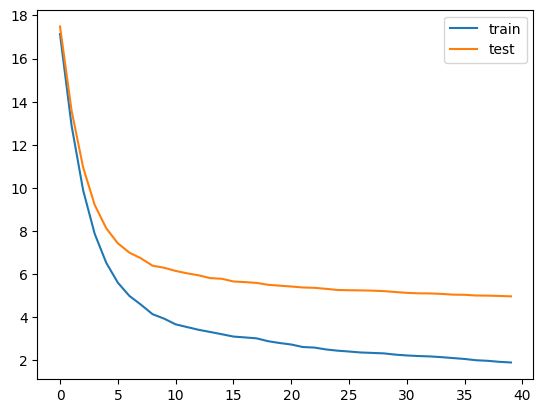

In [102]:
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['rmse'][10:], label='train')
plt.plot(results['validation_1']['rmse'][10:], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [22]:
# shap_values = model.predict(X_test, pred_contribs=True)

In [ ]:
explainer = shap.Explainer(model.predict, X_test, max_evals=20000)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [ ]:
# shap_interaction_values = model.predict(dtrain_reg, pred_interactions=True)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)[0]
print(shap_values)

shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_train[0, :],
    matplotlib=True,
)